In [2]:
from mxnet import image
from mxnet import nd
data_dir = '/home/universe/.mxnet/datasets/data/pikachu/'

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names=['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

In [3]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


[ 83.6886   67.84641 108.21426 116.15701]
[ 9.490609 22.89141  45.725037 84.716965]
[138.87224   28.352415 186.75198   86.019394]
[168.69392  82.52683 206.1004  132.1542 ]


<function matplotlib.pyplot.show>

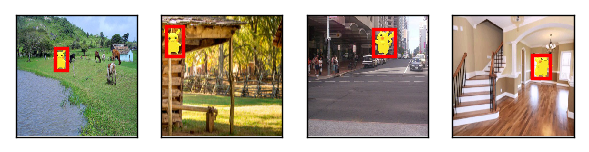

In [14]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
from matplotlib import pyplot as plt

def bbox_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    print(box)
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(1, 4, figsize=(6,6))
for i in range(4):
    img, labels = batch.data[0][i], batch.label[0][i]
    img = img.transpose((1, 2, 0)) + rgb_mean
    img = img.clip(0,255).asnumpy()/255
    fig = figs[i]
    fig.imshow(img)
    for label in labels:
        rect = bbox_to_rect(label[1:5]*data_shape, 'red', 2)
        fig.add_patch(rect)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show


In [19]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

# shape: batch x channel x height x weight
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])
boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]


(40, 40, 5, 4)



[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>

In [22]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(bbox_to_rect(anchors[i,:]*n, colors[i]))
plt.show()


In [28]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

In [27]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

In [31]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)


In [32]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.random.uniform(shape=(2,3,256,256))
y = bnet(x)
y.shape

(2, 64, 32, 32)

In [41]:
def toy_ssd_model(num_anchors, num_classes):
    downsamples = nn.Sequential()
    for _ in range(3):
        downsamples.add(down_sample(128))
    
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
    
    model = nn.Sequential()
    model.add(body(), downsamples, class_predictors, box_predictors)
    return model

In [42]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):
    body, downsamples, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    
    #feature extraction
    x = body(x)
    for i in range(5):
        anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(flatten_prediction(class_predictors[i](x)))
        box_preds.append(flatten_prediction(box_predictors[i](x)))
        if verborse:
            print('Predict scale', i, x.shape, 'with', anchors[-1].shape[1], 'anchors')
            
         # down sample
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max',
                kernel=(x.shape[2], x.shape[3]))
        
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

In [43]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        self.sizes = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)
    
    def fword(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, verbose=self.verbose)
        
        # it is better to have class predictions reshaped for softmax computation
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

        

In [45]:
net = ToySSD(num_classes=2, verbose=True)
net.initialize()
x = batch.data[0][0:1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output achors:', anchors.shape)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

NameError: name 'downsamplers' is not defined